<a href="https://colab.research.google.com/github/CeesGniewyk/Food-Classification/blob/master/VGG16/Food_Classifications_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the notebook where I will be training a food model using the pretrained VGG-16 model. <br>
The data that has been used is the *Food-11* dataset ,the data has not been stored in Github but can be found here: https://www.epfl.ch/labs/mmspg/downloads/food-image-datasets/. <br>
The dataset will be explored and trained in this notebook.<br>
The data has been stored in my Google drive, this made extracting the data and working with it faster.

# Google Drive mounting

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Packages

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Reshape, Activation

def plotplease():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Pickle for storing files
import pickle
def load_file(file_name):
    f = open(file_name, 'rb')
    read_file = pickle.load(f)
    print("file loaded")
    f.close()
    return read_file

def save_file(file_name, data):
    f = open(file_name, 'wb')
    pickle.dump(data, f, protocol=4)
    print(" file saved")
    f.close()

%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11

/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11


# Load Data


In [0]:
train = [os.path.join("training",img) for img in os.listdir("training")]
val = [os.path.join("validation",img) for img in os.listdir("validation")]
test = [os.path.join("evaluation",img) for img in os.listdir("evaluation")]
print(len(train), len(val),len(test))

9866 3430 3347


The dataset comprises of 9866 training images, 3430 validation images and 3347 test images.

# Pre Process

In [0]:
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 11
y_train = utils.to_categorical(train_y, num_classes)
y_val = utils.to_categorical(val_y, num_classes)
y_test = utils.to_categorical(test_y, num_classes)

Training data available in 11 classes
[994, 429, 1500, 986, 848, 1325, 440, 280, 855, 1500, 709]


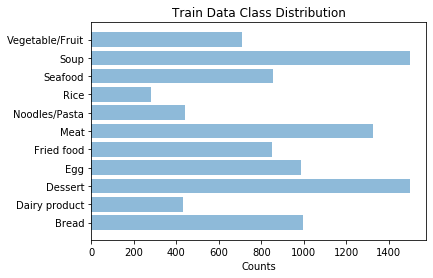

Validation data available in 11 classes
[362, 144, 500, 327, 326, 449, 147, 96, 347, 500, 232]
Test data available in 11 classes
[368, 148, 500, 335, 287, 432, 147, 96, 303, 500, 231]


In [0]:
print("Training data available in 11 classes")
print([train_y.count(i) for i in range(0,11)])

food_classes = ('Bread','Dairy product','Dessert','Egg','Fried food','Meat',
           'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit')
categories = ['Bread','Dairy product','Dessert','Egg','Fried food','Meat',
           'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit']
y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(0,11)]

plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')

plt.show()

print("Validation data available in 11 classes")
print([val_y.count(i) for i in range(0,11)])
print("Test data available in 11 classes")
print([test_y.count(i) for i in range(0,11)])

Here the 11 classes that the images belong to have been shown. <br>
From the bar chart it can be seen that the classes are reasonable balanced, some classes are represented a bit more, but there is no shocking disbalance.

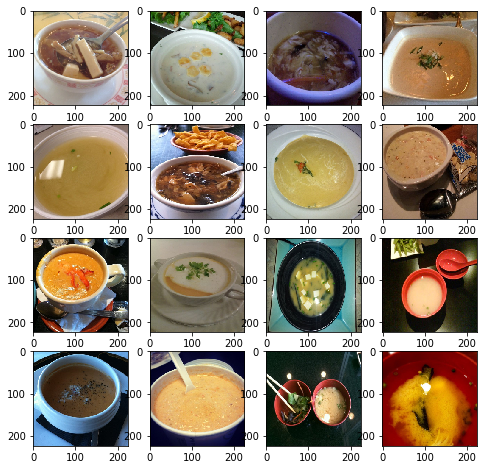

In [0]:
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()
show_imgs(train)

## Feature Extraction
Custom function to extract features of each image in Food-11 dataset using VGG16 model

In [0]:
def create_features(dataset):
    a = []
    for imagePath in tqdm(dataset):
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)    
        a.append(image)    
    x = np.vstack(a)
    return x

The feature being extracted for each dataset train, val and test is the raw input image (224,224,3). This image is rescaled using the imagenet_utils.preprocess_input function. <br>
This only has to be done once, because we save the features afterwards. <br>
In the future we can load the arrays that represent the images instead.


In [0]:
# Don't run in one go, not enough RAM, separate and do each set by itself
train_x = create_features(train)
val_x = create_features(val)
test_x = create_features(test)

/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11


In [0]:
# Don't run in one go, not enough RAM, separate and do each set by itself
save_file("VGG16 Model/training_data.p",train_x)
save_file("VGG16 Model/validation_data.p",val_x)
save_file("VGG16 Model/testing_data.p",test_x)

/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/Efficientnet_Model_244
 file saved


### Loading Saved Features

In [0]:
train_x = load_file("VGG16 Model/training_data.p")
test_x = load_file("VGG16 Model/testing_data.p")
val_x = load_file("VGG16 Model/validation_data.p")

file loaded
file loaded
file loaded


# Modelling

In this part we will be doing the transfer learning. <br>
VGG16 is a famous network from a group called "Oxfort Visual Geometry Group",they won a competition in 2014 and released a paper shortly after. <br>
In the competition they won the classification task on the "Imagenet" dataset <br> which is a dataset that has 1000 classes. <br>
They've released two versions of their model, the 16 layered version and the 19 layered version to the public. <br>
We'll be using the weights of the VGG-16 that was trained on the imagenet dataset. <br>
Now there is already a lot of information stored in the VGG Model, the first layers can also be considered feature extractors, where main features that are in the pictures are extracted. <br>
Therefore it would be wise to use this information and not retrain it when we're finetuning our model when training it for our Food-11 dataset. <br>
We will be adding some layers on top of the VGG-16 layer, to help with learning the finetuned information. <br>
To not change the upper
For this we will be using a function that makes the layers non-trainable. So they don't change. This is called "Freezing Layers" we'll be testing out two methods. <br>
Firstly by a larger part of the VGG-16 architecture and secondly by only freezing the last part of it. <br>
Freezing the entire network would slow down training too much and wouldn't be beneficial.

## Fine Tuning VGG16 : Transfer Learning

### Freezing half the network

First we will load the VGG16 Model that was trained on the imagenet, without adding the last embedding layer.

#### Loading VGG16 Model

In [0]:
# load the VGG16 network, specify include_top = False to not have the last classification layer.
model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now we will make the layers non-trainable, you can see that False means they cannot be trained

In [0]:
# Freeze the layers except the last 9 layers
for layer in model_vgg.layers[:-9]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model_vgg.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f364014ac18> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f364014a898> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f364014fc18> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f364016bc18> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f364016bc50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f364017e780> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f364010bdd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f364010be10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f364011b978> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f364012afd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f364013a668> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0

#### Building Model

In this step we add our custom layers to the bottom of the VGG network. <br>
The Dense layer of size 11 is the classification layer that will make the prediction.

In [0]:
model = Sequential()
model.add(model_vgg)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 14,767,099
Trainable params: 13,031,611
Non-trainable params: 1,735,488
_________________________________________________________________


We train the model and use Early Stopping to not let the model overfit too much. <br>
We save the best performing model.

In [0]:
%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/VGG16 Model
# Creating a checkpointer 

cbs = [EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min'),
       ModelCheckpoint(filepath='half_freeze_model.hdf5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')
       ]
opt = Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model.fit(train_x, y_train, batch_size=32, epochs=50,
          validation_data=(val_x, y_val), callbacks=cbs,verbose=1, shuffle=True)

/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/VGG16 Model
Train on 9866 samples, validate on 3430 samples
Epoch 1/50
9856/9866 [============================>.] - ETA: 0s - loss: 1.0010 - acc: 0.6770
Epoch 00001: val_loss improved from inf to 0.75755, saving model to half_freeze_model.hdf5
9866/9866 [==============================] - 46s 5ms/sample - loss: 1.0007 - acc: 0.6772 - val_loss: 0.7575 - val_acc: 0.7577
Epoch 2/50
9856/9866 [============================>.] - ETA: 0s - loss: 0.6184 - acc: 0.8001
Epoch 00002: val_loss improved from 0.75755 to 0.59285, saving model to half_freeze_model.hdf5
9866/9866 [==============================] - 46s 5ms/sample - loss: 0.6184 - acc: 0.8001 - val_loss: 0.5929 - val_acc: 0.8122
Epoch 3/50
9856/9866 [============================>.] - ETA: 0s - loss: 0.4366 - acc: 0.8592
Epoch 00003: val_loss improved from 0.59285 to 0.56590, saving model to half_freeze_model.hdf5
9866/9866 [==============================] - 4

The model ended training after 14 epochs, with a maximum accuracy on the validation set that was 87%

#### Accuracy and Loss Plot

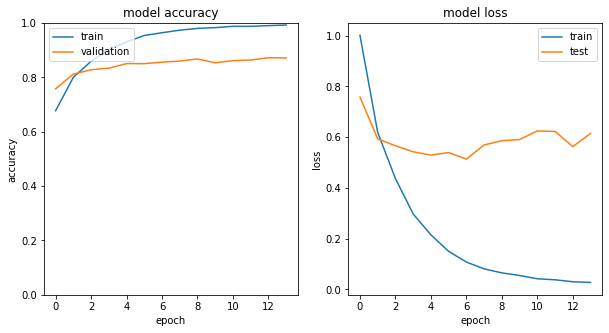

In [0]:
def plot_accuracy_loss(history):    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim([0, 1])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_accuracy_loss(history)

#### Test Evaluation

In [0]:
prediction = np.argmax(model.predict(test_x), axis=1)
print("Accuracy on Test Data: ", accuracy_score(test_y, prediction))

Accuracy on Test Data:  0.8945324170899313


You can see that on the test set it performed with an accuracy of 89% <br>
Next we see how the model performs if we freeze less layers.

### Fine Tuning -Freezing Half- Network

#### Load Half Tunable VGG16 Model

This time we only freeze the last convolutional block, so only the last 4 layers.

In [0]:
# load the VGG16 network 
model_vgg_2 = VGG16(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])

# Freeze the layers except the last 4 layers
for layer in model_vgg_2.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model_vgg_2.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f33ab4bb898> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f33ab4bba58> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f33ab4c1470> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f33ab5c6ac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f33ab4ddf28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f33ab4e1668> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f33ab4eecc0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f33ab4eecf8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f33ab481860> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f33ab48deb8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f33ab49e518> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

#### Building Model

In [0]:
model_2 = Sequential()
model_2.add(model_vgg_2)
model_2.add(GlobalAveragePooling2D())
model_2.add(Dropout(0.2))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(11, activation='softmax'))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_5 (Dense)              (None, 11)                1111      
Total params: 14,767,099
Trainable params: 7,131,835
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/VGG16 Model
# Creating a checkpointer 

cbs = [EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min'),
       ModelCheckpoint(filepath='quarter_freeze_model.hdf5', save_best_only=True, monitor='val_loss', verbose=1, mode='min')
       ]
opt = Adam(lr=0.00001)
model_2.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_2.fit(train_x, y_train, batch_size=32, epochs=50,
          validation_data=(val_x, y_val), callbacks=cbs,verbose=1, shuffle=True)

/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/VGG16 Model
Train on 9866 samples, validate on 3430 samples
Epoch 1/50
9856/9866 [============================>.] - ETA: 0s - loss: 2.3112 - acc: 0.3235
Epoch 00001: val_loss improved from inf to 1.28112, saving model to quarter_freeze_model.hdf5
9866/9866 [==============================] - 37s 4ms/sample - loss: 2.3103 - acc: 0.3235 - val_loss: 1.2811 - val_acc: 0.5790
Epoch 2/50
9856/9866 [============================>.] - ETA: 0s - loss: 1.1254 - acc: 0.6323
Epoch 00002: val_loss improved from 1.28112 to 0.86060, saving model to quarter_freeze_model.hdf5
9866/9866 [==============================] - 37s 4ms/sample - loss: 1.1253 - acc: 0.6324 - val_loss: 0.8606 - val_acc: 0.7207
Epoch 3/50
9856/9866 [============================>.] - ETA: 0s - loss: 0.7738 - acc: 0.7457
Epoch 00003: val_loss improved from 0.86060 to 0.69535, saving model to quarter_freeze_model.hdf5
9866/9866 [==========================

#### Accuracy and Loss Plot

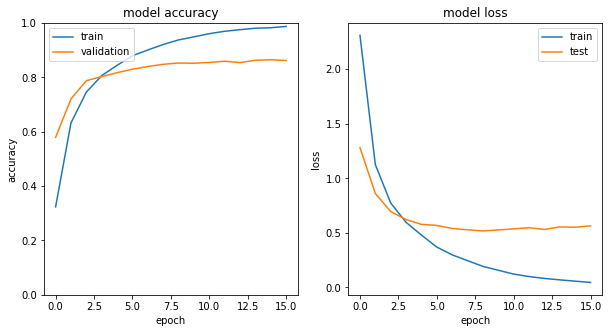

In [0]:
plot_accuracy_loss(history)

#### Test Evaluation

In [0]:
prediction = np.argmax(model_2.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, prediction))


Accuracy on Test Data:  0.8912458918434419


As you can see the models perform similarly on the training on the training set, the extra freezing didn't have that large of an impact. <br>

#Testing Model on own data

In the following section, I try to see if I can get prediction on my own data,this was done first before it was exported to the raspberry pi. 



## Loading Model

In [0]:
%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11
model = load_model("VGG16 Model/half_freeze_model.hdf5")
model.summary()

/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
de

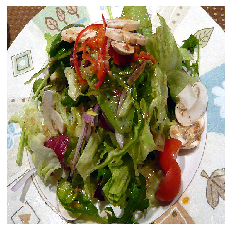

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


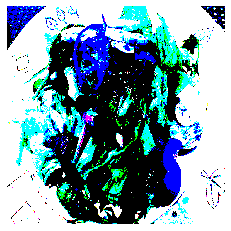

Class is: Vegetable/Fruit
Predicted Class is: Vegetable/Fruit


In [0]:
#@title Summary {run:"auto"}
example_id = 2190 #@param {type:"slider", min:0, max:3346, step:1}
image = load_img(test[example_id], target_size=(224, 224))
label = test_y[example_id]
plt.imshow(image)
plt.axis("off")
plt.show()
plt.imshow(test_x[example_id])
plt.axis("off")
plt.show()
print("Class is: {}".format(categories[label]))
x = np.expand_dims(example_id, axis=0)
prediction = model.predict(test_x[x])
print("Predicted Class is: {}".format(categories[np.argmax(prediction)]))

#Uploading Personal Photos

In [0]:
personal = [os.path.join("personal",img) for img in os.listdir("personal")]
print(len(personal))

In [0]:
os.listdir()

['evaluation',
 'training',
 'validation',
 'bestmodel.hdf5',
 'personal',
 'VGG16 Model',
 'validation_data.p',
 'efficientnet_keras_transfer_learning',
 'testing_data.p']

In [0]:
personal

['personal/IMG_20191202_163523.jpg',
 'personal/IMG_20191202_163543.jpg',
 'personal/IMG_20191202_163546.jpg',
 'personal/IMG_20191202_163517.jpg',
 'personal/IMG_1767.jpg',
 'personal/IMG_20191025_175314.jpg',
 'personal/download.jfif',
 'personal/download (1).jfif',
 'personal/IMG_20191206_141708.jpg',
 'personal/IMG_20191206_142611.jpg',
 'personal/IMG_20191206_142615.jpg',
 'personal/IMG_20191206_142608.jpg',
 'personal/IMG_20191206_150536.jpg',
 'personal/IMG_20191206_150538.jpg',
 'personal/IMG_20191206_150541.jpg',
 'personal/IMG_20191209_175132.jpg',
 'personal/IMG_20200110_152350.jpg']

In [0]:
personal_x = create_features(personal)

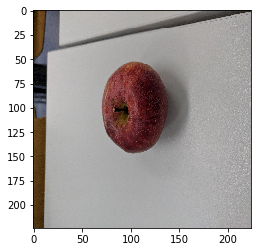

In [0]:
plt.imshow(personal_x[14])

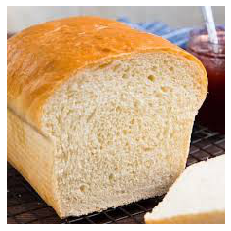

Predicted Class is: Soup


In [0]:
#@title Summary {run:"auto"}
example_id = 6 #@param {type:"slider", min:0, max:16, step:1}
image = load_img(personal[example_id], target_size=(224, 224))
# label = test_y[example_id]
plt.imshow(image)
plt.axis("off")
plt.show()
# print("Class is: {}".format(categories[label]))
x = np.expand_dims(example_id, axis=0)
prediction = model.predict(personal_x[x])
print("Predicted Class is: {}".format(categories[np.argmax(prediction)]))